In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

from M1S_tools import *

plt.jet()

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

In [2]:
dataFolder = './'
df = pd.read_excel(dataFolder+'gmt3_final_forces_english.xlsx', skiprows=2)
nact_sw = len(df)
print('Number of actuators = ', nact_sw)

Number of actuators =  170


In [3]:
df 

,act #,LS type,x_opt (in),y_opt (in),f_FEM (lbs),f_active (lbs),f_FEM+f_active (lbs),newquad_corr (lbs),gmto_zfrc (lbs)
0,101,TA,-0.000559,-30.58141,201.150925,7.084308,208.235232,0.0,208.235232
1,102,TA,-0.000185,-56.79406,224.518482,6.094627,230.613109,0.0,230.613109
2,103,TA,0.000184,-83.00670,228.737195,-1.573539,227.163657,0.0,227.163657
3,104,TA,-0.000304,-109.21980,234.534074,-6.584757,227.949317,0.0,227.949317
4,105,TA,0.000059,-135.43250,243.606368,-2.657327,240.949041,0.0,240.949041
...,...,...,...,...,...,...,...,...,...
165,1335,D,110.315000,94.92300,159.874566,-0.187590,159.686976,0.0,159.686976
166,1212,D,-21.269490,154.76640,202.238838,3.545953,205.784792,0.0,205.784792
167,1235,D,-110.315000,94.92300,160.151122,3.991052,164.142174,0.0,164.142174
168,1412,D,21.274950,-154.76570,202.383838,4.564636,206.948473,0.0,206.948473


In [4]:
lbs2N = 4.4482216153
in2mm = 25.4
sax_sw = np.array(df['y_opt (in)'])*in2mm/1000 #swap x/y to get to M1B (M1DCS uses M1B!!!)
say_sw = np.array(df['x_opt (in)'])*in2mm/1000
f_FEM = np.array(df['f_FEM (lbs)'])*lbs2N
f_active = np.array(df['f_active (lbs)'])*lbs2N
f_quad = np.array(df['newquad_corr (lbs)'])*lbs2N
f_corr = np.array(df['gmto_zfrc (lbs)'])*lbs2N
saID_sw_q = np.array(df['act #']) #steve west assigned these IDs, whether they are same as Trupti's is Questionable

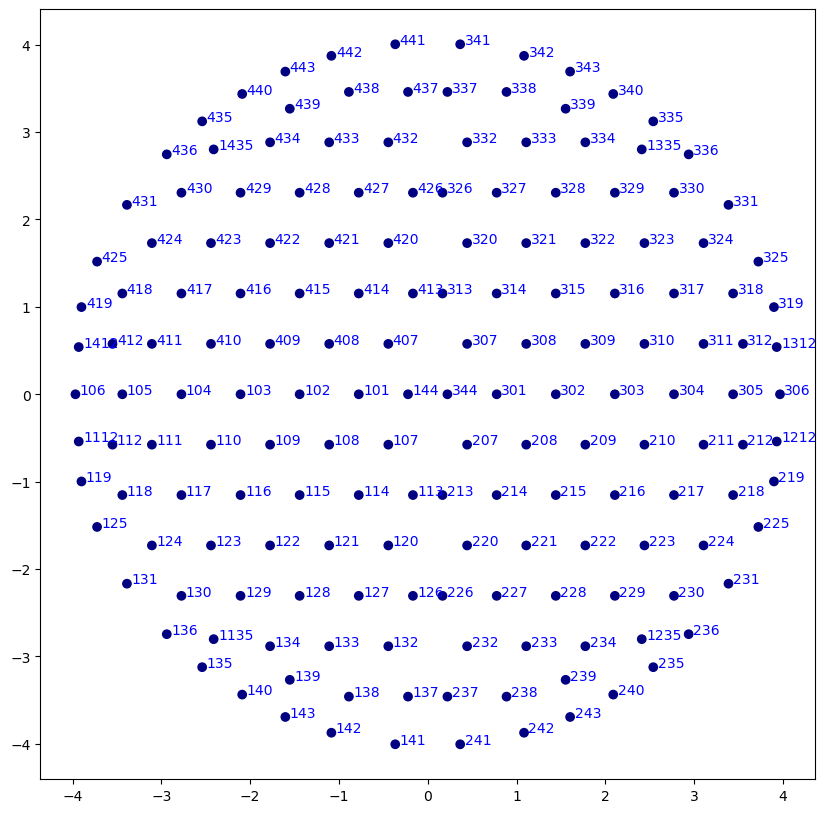

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(sax_sw, say_sw, c=np.ones(170))
for i in range(nact_sw):
    if (np.any(abs(sax_sw[i]+say_sw[i]-sax_sw[:i]-say_sw[:i])<1e-4)):
        #if two actuators have same x/y, we label it as red
        plt.text(sax_sw[i]+.05, say_sw[i]-0.15, str(saID_sw_q[i]),color='r')
    else:
        plt.text(sax_sw[i]+.05, say_sw[i], str(saID_sw_q[i]),color='b')

In [6]:
#steve do have 170 SAs, but his IDs are not be identical to Trupti's
#for example, Steve's 1335 is inside of 335, and the pairs of SAs on the quads have different coordinates.

saID_sw = np.zeros(len(sax_sw))
sa_offset = np.zeros(len(sax_sw))
for i in range(len(sax_sw)):
    offsetVec = np.hypot(sax_sw[i]-sax, say_sw[i]-say)
    found = np.where(offsetVec<0.1)[0] #less than 0.1meter
    if len(found)==1:
        offset = offsetVec[found]
        saID_sw[i] = int(saID[found])
        #print(found)
    else:
        if sax_sw[i]<0:
            if say_sw[i]>2:
                saID_sw[i] = 1326
            elif say_sw[i]>1:
                saID_sw[i] = 1313
            elif say_sw[i]<-2:
                saID_sw[i] = 126
            elif say_sw[i]<-1:
                saID_sw[i] = 113
            else:
                saID_sw[i] = 144
        elif sax_sw[i]>0:
            if say_sw[i]>2:
                saID_sw[i] = 326
            elif say_sw[i]>1:
                saID_sw[i] = 313
            elif say_sw[i]<-2:
                saID_sw[i] = 1126
            elif say_sw[i]<-1:
                saID_sw[i] = 1113     
            else:
                saID_sw[i] = 1144
        #print(saID_sw[i], 'xxxxxxxxx')
        offset = offsetVec[saID_sw[i]==saID]
    if abs(saID_sw_q[i]-saID_sw[i])>0.1:
        print('---- ID_sw_q ',  saID_sw_q[i], ' gmt ID %d'%saID_sw[i] )
    sa_offset[i] = offset

---- ID_sw_q  213  gmt ID 1113
---- ID_sw_q  226  gmt ID 1126
---- ID_sw_q  344  gmt ID 1144
---- ID_sw_q  413  gmt ID 1313
---- ID_sw_q  426  gmt ID 1326
---- ID_sw_q  135  gmt ID 1135
---- ID_sw_q  335  gmt ID 1335
---- ID_sw_q  235  gmt ID 1235
---- ID_sw_q  435  gmt ID 1435
---- ID_sw_q  1135  gmt ID 135
---- ID_sw_q  1335  gmt ID 335
---- ID_sw_q  1235  gmt ID 235
---- ID_sw_q  1435  gmt ID 435


In [24]:
#np.savetxt('saID_sw.txt', saID_sw)

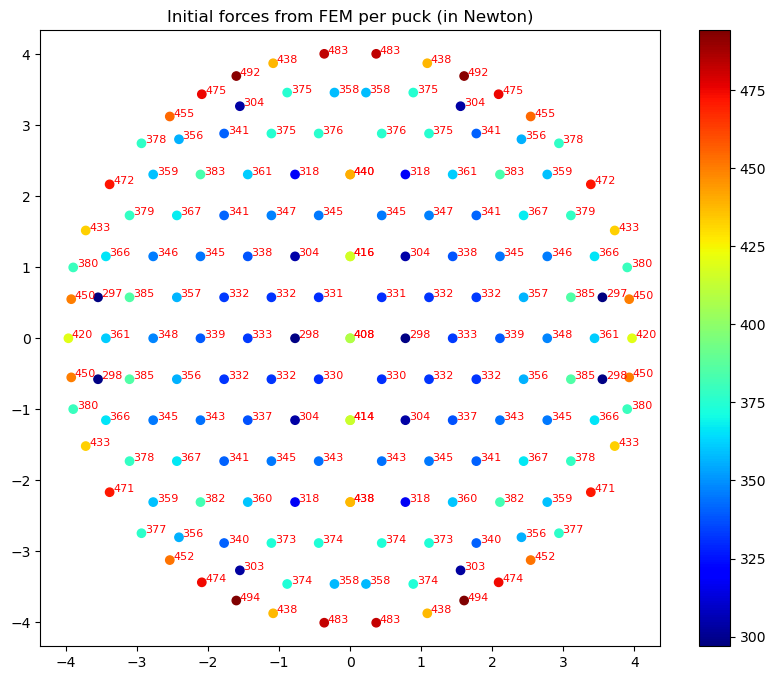

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
aa = swFvec2gmtFvec(f_FEM)/npuck
plt.scatter(sax, say, c=aa)
plt.colorbar()
plt.axis('equal')
for i in range(nact):
    plt.text(sax[i]+.05, say[i], '%.0f'%aa[i],color='r',fontsize=8)
plt.title('Initial forces from FEM per puck (in Newton)');

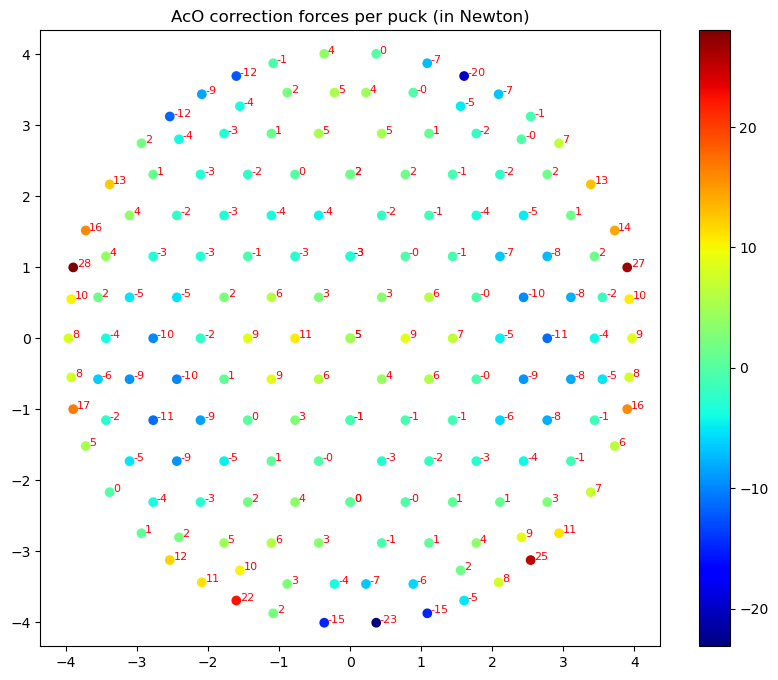

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
aa = swFvec2gmtFvec(f_active)/npuck
plt.scatter(sax, say, c=aa)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%aa[i],color='r',fontsize=8)
plt.title('AcO correction forces per puck (in Newton)');

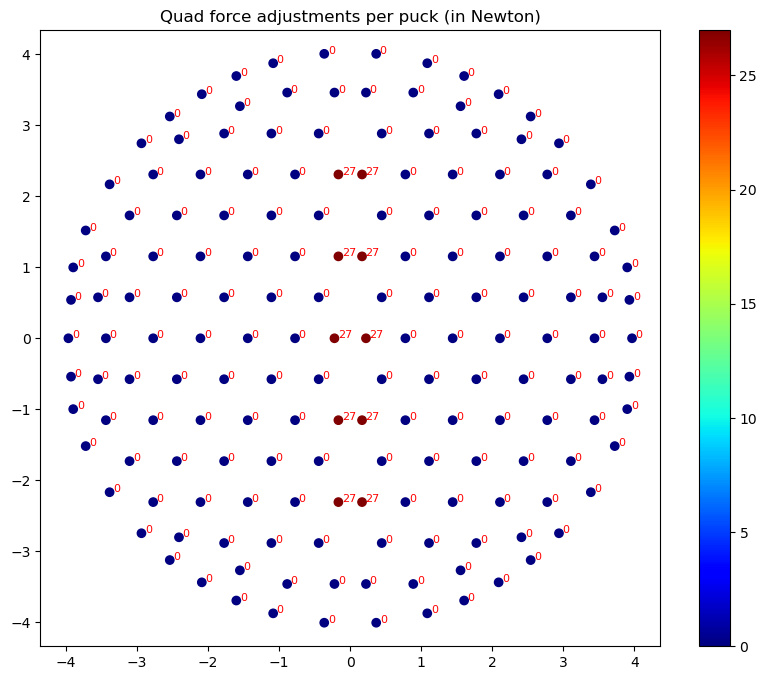

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(sax_sw, say_sw, c=f_quad)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax_sw)):
    plt.text(sax_sw[i]+.05, say_sw[i], '%.0f'%f_quad[i],color='r',fontsize=8)
plt.title('Quad force adjustments per puck (in Newton)');

Text(0.5, 1.0, 'Initial support forces per puck (in Newton)')

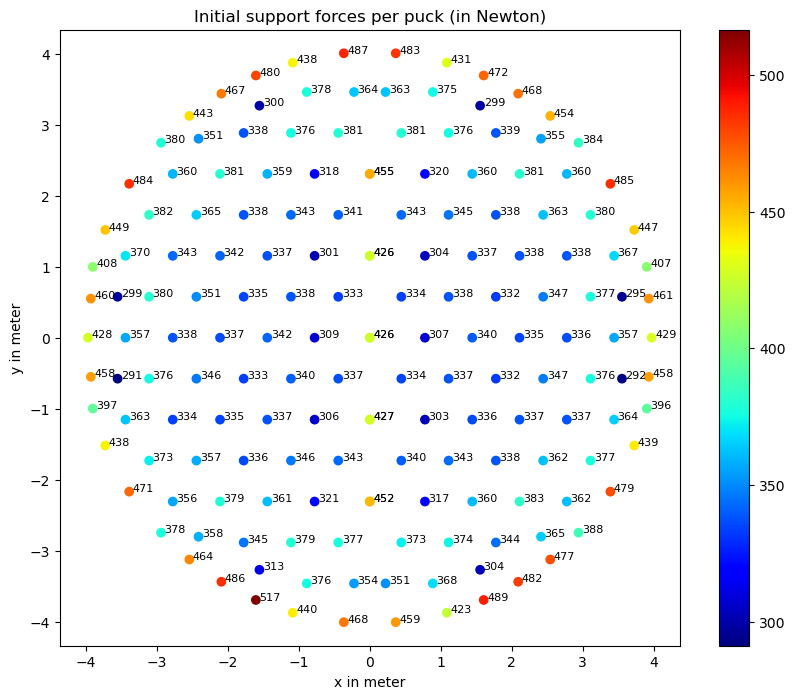

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
aa = swFvec2gmtFvec(f_corr)/npuck
plt.scatter(sax, say, c=aa)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%aa[i],color='k',fontsize=8)
plt.xlabel('x in meter')
plt.ylabel('y in meter')
plt.title('Initial support forces per puck (in Newton)')